# E2f1 perturbation on pancreatic endocrine dataset

Notebook for analyzing cell cycling population in pancreatic endocrine

## Library imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, pearsonr

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output
from rgv_tools.perturbation import in_silico_block_simulation
from rgv_tools.utils import cosine_dist, min_max_scaling

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo_t

## General settings

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "pancreatic_endocrinogenesis"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [6]:
TERMINAL_STATES = ["Beta", "Alpha", "Delta", "Epsilon"]

In [7]:
PALETTE = {"Gene expression": "#555555", "KL divergence": "#ffc0cb"}

In [8]:
MODEL = DATA_DIR / DATASET / "processed" / "rgv_model"

## Data loading

In [9]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
TF = adata.var_names[adata.var["tf"]]

## Calculate cell cycling score

In [12]:
scv.tl.score_genes_cell_cycle(adata)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


Excluded `G1` phase and focus on the regulator during `G2M` to `S` phase transition

In [13]:
adata_raw = adata.copy()
bdata = adata[adata.obs["phase"] != "G1"].copy()

Ranking the TFs according to their correlation with cell state transition

In [14]:
score = min_max_scaling(bdata.obs["S_score"]) - min_max_scaling(bdata.obs["G2M_score"])
gene_ranking = []
for i in range(bdata.shape[1]):
    gene_ranking.append(pearsonr(bdata.X.A[:, i], score)[0])
rank_df = pd.DataFrame({"Ranking": gene_ranking})
rank_df.index = bdata.var_names.tolist()

In [16]:
TF = bdata.var_names[bdata.var["tf"]]
rank_df.loc[TF, :].sort_values(by="Ranking", ascending=False)

,Ranking
index,
E2f1,0.294368
Sox5,0.074033
Klf10,0.065834
Rest,0.055055
Tcf7l2,0.043340
...,...
Atoh8,-0.079180
Foxn3,-0.097777
Atf3,-0.102710


We recovered E2f1 is the top regulator of cell state transition, we can visualize its expression pattern

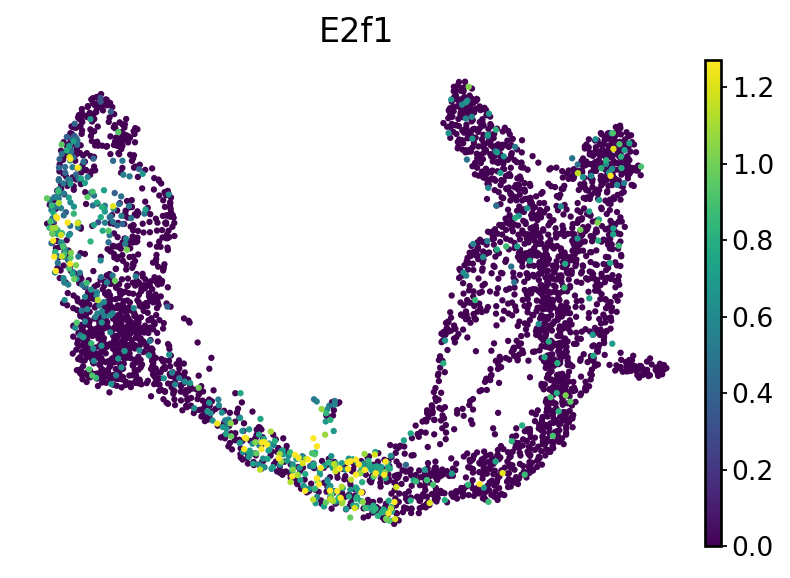

In [17]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(adata, color="E2f1", vmin="p1", vmax="p99", frameon=False, ax=ax)

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / DATASET / "E2f1_express.svg", format="svg", transparent=True, bbox_inches="tight")

## Perform E2f1 perturbation simulation

### Model loading

Define reference vector field

In [18]:
vae = REGVELOVI.load(MODEL, adata)
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/rgv_model/model.pt 
         already downloaded                                                                                        


### Simulate perturbation

In [19]:
adata_perturb, vae_perturb = in_silico_block_simulation(MODEL, adata, "E2f1", effects=0)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/pancreatic_endocrine/processed/rgv_model/model.pt 
         already downloaded                                                                                        


### Define local perturbation effects

In [20]:
ko_effect = cosine_dist(adata.layers["velocity"].T, adata_perturb.layers["velocity"].T)
adata_perturb.obs["perturbation_effect"] = ko_effect

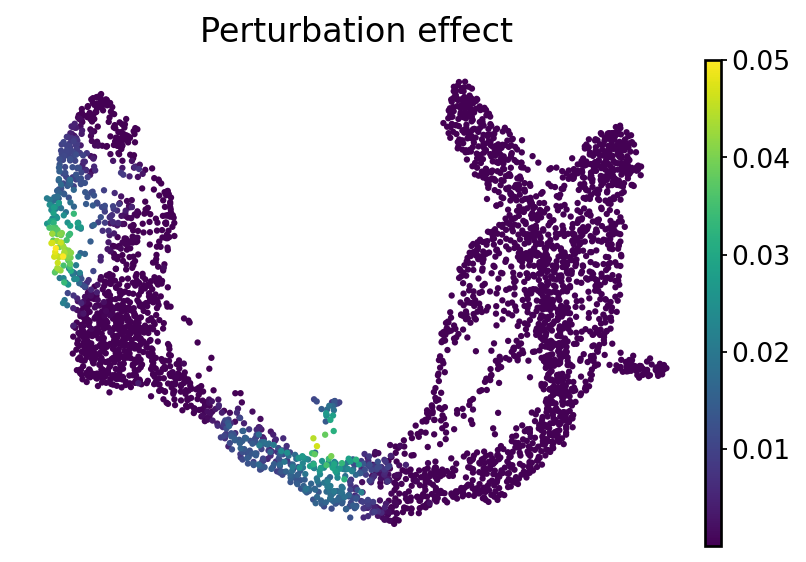

In [21]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(
        adata_perturb,
        color="perturbation_effect",
        cmap="viridis",
        title="Perturbation effect",
        ax=ax,
        frameon=False,
    )

if SAVE_FIGURES:
    fig.savefig(FIG_DIR / DATASET / "E2f1_perturbation_effect.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

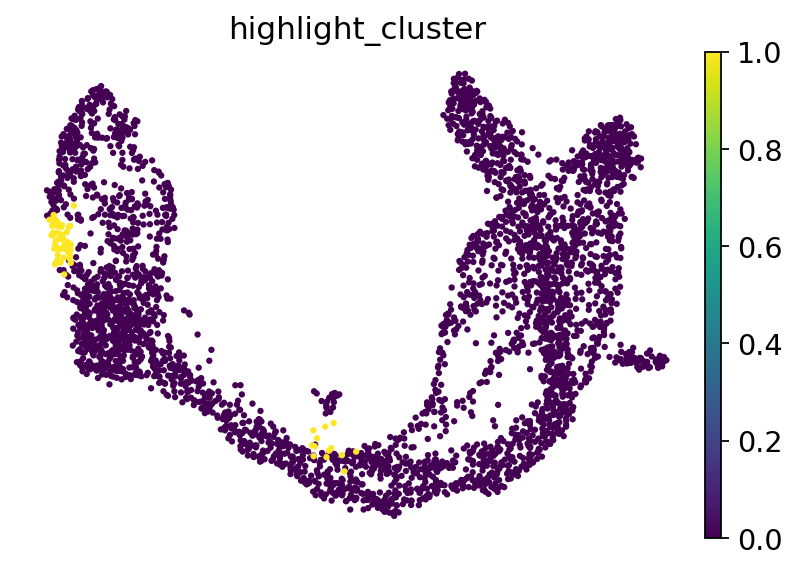

In [24]:
adata_perturb.obs["highlight_cluster"] = 0
adata_perturb.obs["highlight_cluster"][np.array(ko_effect) > 0.03] = 1
sc.pl.umap(
    adata_perturb,
    color="highlight_cluster",
    frameon=False,
)

In [25]:
adata_perturb.obs["s_phase"] = 0
adata_perturb.obs["s_phase"][adata_perturb.obs["phase"] == "S"] = 1

In [26]:
crosstab = pd.crosstab(adata_perturb.obs["highlight_cluster"], adata_perturb.obs["s_phase"], margins=False)

In [27]:
_, p_value = fisher_exact(crosstab, alternative="two-sided")

In [28]:
p_value

6.439914211807307e-40

## Highlight the inconsistency between perturbation effects and gene expression

Measuring the average perturbation effects in `Ductal`, `Ngn3 high EP`, and `Ngn3 low EP` (E2f1 is found to be the most highly expressed in these cell types.)

In [29]:
PS = (
    adata_perturb.obs["perturbation_effect"][
        (adata_perturb.obs["clusters"] == "Ductal") & (adata_perturb.obs["phase"] == "S")
    ].tolist()
    + adata_perturb.obs["perturbation_effect"][adata_perturb.obs["clusters"] == "Ngn3 high EP"].tolist()
    + adata_perturb.obs["perturbation_effect"][adata_perturb.obs["clusters"] == "Ngn3 low EP"].tolist()
)

In [30]:
label = (
    [2] * np.sum((adata_perturb.obs["clusters"] == "Ductal") & (adata.obs["phase"] == "S"))
    + [1] * np.sum(adata_perturb.obs["clusters"] == "Ngn3 high EP")
    + [0] * np.sum(adata_perturb.obs["clusters"] == "Ngn3 low EP")
)
# KL = scipy.stats.zscore(KL)
PS = np.array(PS)
PS = [np.mean(PS[np.array(label) == 2]), np.mean(PS[np.array(label) == 0]), np.mean(PS[np.array(label) == 1])]
PS = PS / np.sqrt(np.var(PS))
# scipy.stats.pearsonr(np.array(x),np.array(KL))
PS

array([2.85040192, 0.88865522, 3.13982871])

Measuring gene expression

In [31]:
GEX = (
    adata[(adata.obs["clusters"] == "Ductal") & (adata.obs["phase"] == "S"), "E2f1"].X.A.reshape(-1).tolist()
    + adata[adata.obs["clusters"] == "Ngn3 high EP", "E2f1"].X.A.reshape(-1).tolist()
    + adata[adata.obs["clusters"] == "Ngn3 low EP", "E2f1"].X.A.reshape(-1).tolist()
)

In [32]:
GEX = np.array(GEX)
GEX = [np.mean(GEX[np.array(label) == 2]), np.mean(GEX[np.array(label) == 0]), np.mean(GEX[np.array(label) == 1])]
GEX = GEX / np.sqrt(np.var(GEX))
GEX

array([2.0291548 , 0.94210755, 3.38661677])

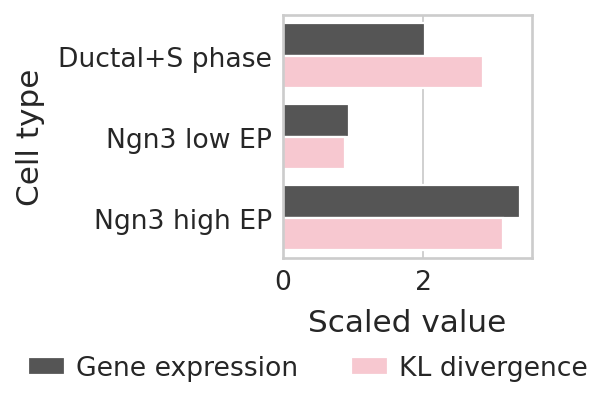

In [33]:
## Visualize the effects through the barplot
sns.set_style("ticks")
figsize = (2, 2)
df = pd.DataFrame(GEX.tolist() + PS.tolist())
df.columns = ["Scaled value"]
df["Cell type"] = ["Ductal+S phase", "Ngn3 low EP", "Ngn3 high EP"] * 2
df["Group"] = ["Gene expression"] * 3 + ["KL divergence"] * 3

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=df,
        x="Scaled value",
        y="Cell type",
        hue="Group",
        ax=ax,
        palette=PALETTE,
    )
    # ax.set(ylim=(-2.1,2.1))
    plt.legend(loc="upper center", bbox_to_anchor=(0.1, -0.3), ncol=2)
    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "perturb_express_compare_e2f1.svg", format="svg", transparent=True, bbox_inches="tight"
        )